In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from scipy.interpolate import \
    interp2d, griddata, RegularGridInterpolator, RectBivariateSpline, \
    NearestNDInterpolator, LinearNDInterpolator

import lbwsg
import lbwsg_plots

!date
!whoami

Mon Mar 22 14:03:10 PDT 2021
ndbs


In [2]:
%load_ext autoreload
%autoreload 2

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Test out updated interpolation code for new RiskEffect class

In [3]:
filename = 'lbwsg_data.hdf'
rr = pd.read_hdf(filename, '/gbd_2019/relative_risk/diarrheal_diseases')
some_rrs = lbwsg.get_relative_risk_set_by_category(rr, draw=0, sex='Male', age_group_id=2)
logrr = np.log(some_rrs)
logrr.head()

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/tables/atom.py:1224: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return pickle.loads(array.tostring())


lbwsg_category
cat2     6.862577
cat8     6.451737
cat10    6.168947
cat11    5.680774
cat14    5.105437
Name: relative_risk, dtype: float64

In [4]:
cat_df = lbwsg.get_category_data()
cat_df.head()

,lbwsg_category,modelable_entity_id,modelable_entity_name,ga_start,ga_end,bw_start,bw_end,ga,ga_width,ga_midpoint,bw,bw_width,bw_midpoint
0,cat2,10755,"Birth prevalence - [0, 24) wks, [0, 500) g",0,24,0,500,"[0, 24)",24,12.0,"[0, 500)",500,250.0
1,cat8,10761,"Birth prevalence - [0, 24) wks, [500, 1000) g",0,24,500,1000,"[0, 24)",24,12.0,"[500, 1000)",500,750.0
2,cat10,10763,"Birth prevalence - [24, 26) wks, [500, 1000) g",24,26,500,1000,"[24, 26)",2,25.0,"[500, 1000)",500,750.0
3,cat11,10764,"Birth prevalence - [26, 28) wks, [500, 1000) g",26,28,500,1000,"[26, 28)",2,27.0,"[500, 1000)",500,750.0
4,cat14,10767,"Birth prevalence - [30, 32) wks, [500, 1000) g",30,32,500,1000,"[30, 32)",2,31.0,"[500, 1000)",500,750.0


# Define intermediate NN interpolation grid, and a dense grid for plotting

In [5]:
interval_data_by_cat = cat_df.set_index('lbwsg_category')
ga_mid = interval_data_by_cat['ga_midpoint']
bw_mid = interval_data_by_cat['bw_midpoint']
assert ga_mid.index.equals(logrr.index) and bw_mid.index.equals(logrr.index)

ga_min = interval_data_by_cat['ga_start'].min()
ga_max = interval_data_by_cat['ga_end'].max()
bw_min = interval_data_by_cat['bw_start'].min()
bw_max = interval_data_by_cat['bw_end'].max()

print(ga_min, ga_max, bw_min, bw_max)

0 42 0 4500


/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
# Intermediate grid: Category midpoints plus boundary points
ga_range = np.append(np.unique(ga_mid), [ga_min, ga_max]); ga_range.sort()
bw_range = np.append(np.unique(bw_mid), [bw_min, bw_max]); bw_range.sort()
print(ga_range, bw_range)
print(ga_range.shape, bw_range.shape)

[ 0.  12.  25.  27.  29.  31.  33.  35.  36.5 37.5 39.  41.  42. ] [   0.  250.  750. 1250. 1750. 2250. 2750. 3250. 3750. 4250. 4500.]
(13,) (11,)


In [7]:
# Dense grid: Fill out the whole GAxBW rectangle
# Use different number of grid points in each direction to easily verify correct orientations
gai = np.linspace(ga_min, ga_max, 200)
bwi = np.linspace(bw_min, bw_max, 150)
print(gai.shape, bwi.shape)

(200,) (150,)


# Create a nearest neighbor interpolator and interpolate to intermediate grid

## Also do it using `griddata` for comparison

In [8]:
%%time
nn_interp = NearestNDInterpolator(list(zip(ga_mid, bw_mid)), logrr, rescale=True)
logrr_nn = nn_interp(ga_range[:,None], bw_range[None,:])
logrr_nn.shape

CPU times: user 1.64 ms, sys: 0 ns, total: 1.64 ms
Wall time: 1.4 ms


(13, 11)

In [9]:
%%time
logrr_nn_griddata = griddata((ga_mid, bw_mid), logrr, (ga_range[:,None], bw_range[None,:]),
                            method='nearest', rescale=True)
print(logrr_nn_griddata.shape)
np.allclose(logrr_nn, logrr_nn_griddata)

(13, 11)
CPU times: user 1.05 ms, sys: 617 µs, total: 1.67 ms
Wall time: 1.3 ms


True

# Create `RectBivariateSpline` and `RegularGridInterpolator`, interpolate to dense grid, and check if results are equal

## Yes, they are!

In [10]:
%%time
rbvspline = RectBivariateSpline(ga_range, bw_range, logrr_nn, kx=1, ky=1)
logrri_rbvspline = rbvspline(gai, bwi)
print(logrri_rbvspline.shape)

(200, 150)
CPU times: user 1.47 ms, sys: 0 ns, total: 1.47 ms
Wall time: 1.1 ms


In [11]:
np.array(np.meshgrid(gai, bwi)).T.shape

(200, 150, 2)

In [12]:
%%time
reggrid = RegularGridInterpolator((ga_range, bw_range), logrr_nn,)
#     method='linear',
#     bounds_error=False,
#     fill_value=None
# )
logrri_reggrid = reggrid(np.array(np.meshgrid(gai, bwi)).T)
print(logrri_reggrid.shape)

(200, 150)
CPU times: user 5.89 ms, sys: 932 µs, total: 6.82 ms
Wall time: 5.73 ms


In [13]:
np.allclose(logrri_rbvspline, logrri_reggrid)

True

In [14]:
ga_range.shape

(13,)

# Let's see if `interp2d` also gives the same results as `RectBivariateSpline` and `RegularGridInterpolator` when using this 2-step approach.

## Yes, it does

Note that we have to transpose z with respect to x and y when using `interp2d`.

Looks like `interp2d` is aligned with `meshgrid` xy-indexing (Cartesian coordinates), while the object-oriented interpolators are transposed, aligned with `meshgrid` ij-indexing (matrix coordinates).

In [15]:
%%time
i2d = interp2d(ga_range, bw_range, logrr_nn.T, kind='linear', bounds_error=False, fill_value=None)
logrri_i2d = i2d(gai, bwi)
print(logrri_i2d.shape)

(150, 200)
CPU times: user 908 µs, sys: 876 µs, total: 1.78 ms
Wall time: 1.48 ms


In [16]:
np.allclose(logrri_rbvspline, logrri_i2d.T)

True

# Let's also create a  `LinearNDInterpolator` to compare

### And also do linear interpolation using `griddata` for comparison

## As expected, these values (linear interpolation) are different from the others (bilinear interpolation)

In [17]:
nn_grid_points = np.array(np.meshgrid(ga_range, bw_range)).T.reshape(-1, 2)
print(nn_grid_points.shape)
print(logrr_nn.reshape(-1).shape)

(143, 2)
(143,)


In [18]:
%%time
lininterp = LinearNDInterpolator(nn_grid_points, logrr_nn.reshape(-1), rescale=True)
logrri_lininterp = lininterp(gai[:,None], bwi[None,:])
print(logrri_lininterp.shape)
np.allclose(logrri_rbvspline, logrri_lininterp)

(200, 150)
CPU times: user 92.5 ms, sys: 136 ms, total: 229 ms
Wall time: 157 ms


False

In [19]:
%%time
logrri_linear_griddata = griddata(
    nn_grid_points, logrr_nn.reshape(-1), (gai[:,None], bwi[None,:]),
    method='linear', rescale=True
)
print(logrri_linear_griddata.shape)
np.allclose(logrri_lininterp, logrri_linear_griddata)

(200, 150)
CPU times: user 14.2 ms, sys: 2.04 ms, total: 16.3 ms
Wall time: 8.98 ms


True

# Finally, create a 2-step nearest neighbor interpolation to see what that looks like

## Notice that this does not give the same interpolation on the whole rectangle as the original nearest neighbor interpolation (see plots below)

### Note also that we can use our `RegularGridInterpolator` object created earlier to do this same NN interpolation

In [20]:
%%time
nn_interp2 = NearestNDInterpolator(nn_grid_points, logrr_nn.reshape(-1), rescale=True)
logrri_nn_interp2 = nn_interp2(gai[:,None], bwi[None,:])
print(logrri_nn_interp2.shape)

(200, 150)
CPU times: user 62 ms, sys: 17.3 ms, total: 79.4 ms
Wall time: 101 ms


In [21]:
%%time
logrri_nn_griddata2 = griddata(nn_grid_points, logrr_nn.reshape(-1), (gai[:,None], bwi[None,:]),
                            method='nearest', rescale=True)
print(logrri_nn_griddata2.shape)
np.allclose(logrri_nn_interp2, logrri_nn_griddata2)

(200, 150)
CPU times: user 34.3 ms, sys: 464 µs, total: 34.8 ms
Wall time: 45.6 ms


True

In [22]:
# Use our RegularGridInterpolator object from earlier, but call with method='nearest'
logrri_reggrid_nn = reggrid(np.array(np.meshgrid(gai, bwi)).T, method='nearest')
print(logrri_reggrid_nn.shape)
np.allclose(logrri_nn_interp2, logrri_reggrid_nn)

(200, 150)


True

# Now interpolate the filled-in grid using our original nearest neighbor interepolation so we can plot the initial NN interpolation 

In [23]:
# Using NearestNDInterpolator object we created earlier
%time logrri_nn = nn_interp(gai[:,None], bwi[None,:])
# Same thing using griddata
%time logrri_nn_griddata = griddata((ga_mid, bw_mid), logrr, (gai[:,None], bwi[None,:]),\
                            method='nearest', rescale=True)
print(logrri_nn_griddata.shape)
print(np.allclose(logrri_nn, logrri_nn_griddata))

CPU times: user 28.9 ms, sys: 278 µs, total: 29.2 ms
Wall time: 27.2 ms
CPU times: user 28.7 ms, sys: 0 ns, total: 28.7 ms
Wall time: 28.2 ms
(200, 150)
True


In [24]:
# Demonstrate that initial NN interpolation is different from 2-step NN interpolation above
np.allclose(logrri_nn, logrri_nn_interp2)

False

# Let's plot stuff!

## First the initial nearest neighbor interpolation

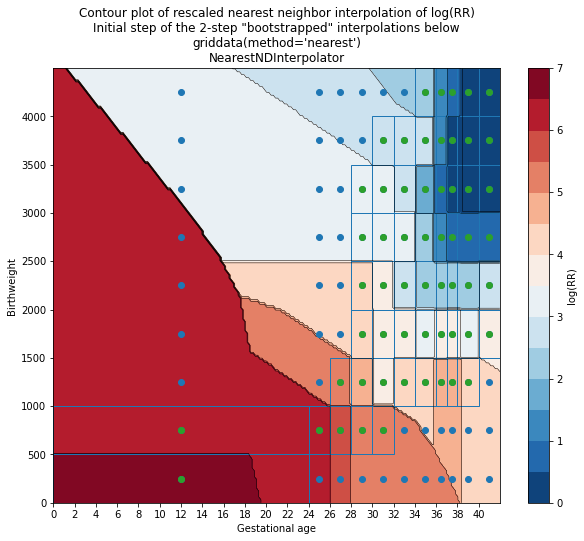

In [25]:
lbwsg_plots.plot_log_rrs(
    gai, bwi, logrri_nn, cat_df,
    logrri_xy_matches_axes=False,
    interpolation_type='rescaled nearest neighbor',
    subtitle='Initial step of the 2-step "bootstrapped" interpolations below'
    "\ngriddata(method='nearest')" "\nNearestNDInterpolator",
    draw_category_rectangles=True, draw_all_gridpoints=True
);

## Now the 2-step nearest neighbor interpolation

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


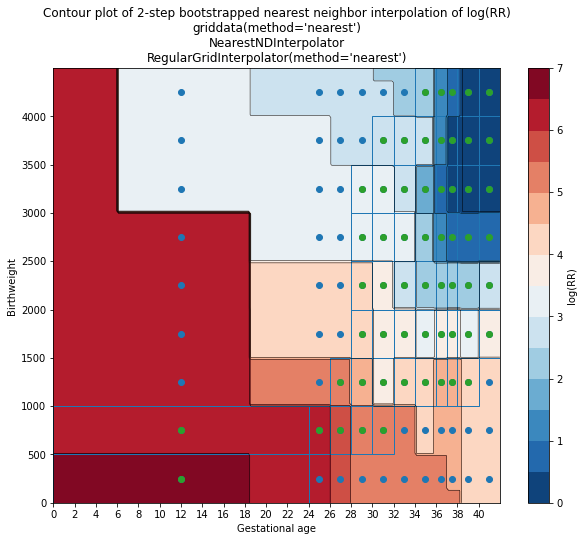

In [26]:
lbwsg_plots.plot_log_rrs(
    gai, bwi, logrri_nn_interp2, cat_df,
    logrri_xy_matches_axes=False,
    interpolation_type='2-step bootstrapped nearest neighbor',
    subtitle="griddata(method='nearest')"
    "\nNearestNDInterpolator"
    "\nRegularGridInterpolator(method='nearest')",
    draw_category_rectangles=True, draw_all_gridpoints=True
);

## Now 2-step linear interpolation

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


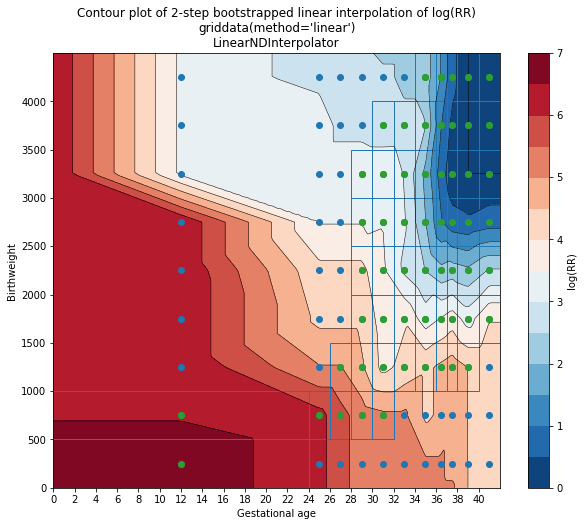

In [27]:
lbwsg_plots.plot_log_rrs(
    gai, bwi, logrri_lininterp, cat_df,
    logrri_xy_matches_axes=False,
    interpolation_type='2-step bootstrapped linear',
    subtitle="griddata(method='linear')"
    "\nLinearNDInterpolator",
    draw_category_rectangles=True, draw_all_gridpoints=True
);

## And finally the 2-step bilinear interpolation, which what we plan to use for LBWSG

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


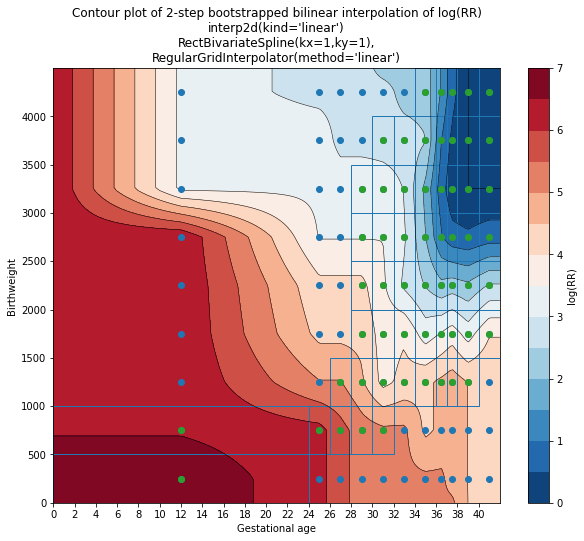

In [28]:
lbwsg_plots.plot_log_rrs(
    gai, bwi, logrri_rbvspline, cat_df,
    logrri_xy_matches_axes=False,
    interpolation_type='2-step bootstrapped bilinear',
    subtitle="interp2d(kind='linear')"
    "\nRectBivariateSpline(kx=1,ky=1),"
    "\nRegularGridInterpolator(method='linear')",
    draw_category_rectangles=True, draw_all_gridpoints=True
);

### Evaluate some RR's in and near the TMREL categories -- near the boundary, they can be >1

In [29]:
np.exp(rbvspline([38, 39.5, 38, 39, 37, 38, 41, 41],
                 [3000, 3250, 4250, 4250, 4250, 3500, 3000, 3500],
                 grid=False))

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([1.46503368, 1.        , 1.57308253, 1.        , 2.91828333,
       1.20180758, 1.47191435, 1.        ])

# Just for fun, try cubic spline interpolation with `RectBivariateSpline` to see what that looks like...

## Looks like overfitting.

In [30]:
%%time
rbvcubicspline = RectBivariateSpline(ga_range, bw_range, logrr_nn, kx=3, ky=3)
logrri_rbvcubicspline = rbvcubicspline(gai, bwi)
print(logrri_rbvcubicspline.shape)

(200, 150)
CPU times: user 1.36 ms, sys: 140 µs, total: 1.5 ms
Wall time: 1.22 ms


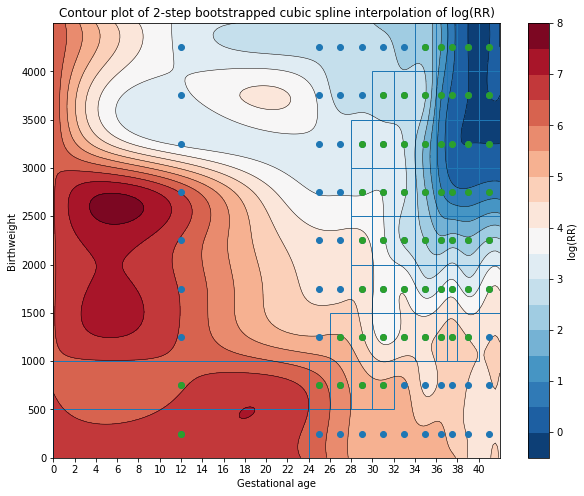

In [31]:
logrri_i2d
lbwsg_plots.plot_log_rrs(
    gai, bwi, logrri_rbvcubicspline, cat_df,
    logrri_xy_matches_axes=False,
    interpolation_type='2-step bootstrapped cubic spline',
    draw_category_rectangles=True, draw_all_gridpoints=True
);

# Check return types/dimensions of interpolators for use in RiskEffect class

Annoyingly, the different interpolators have different call signatures and return arrays of different dimensions.

In [32]:
rbvspline(0,5)

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[6.86257667]])

In [33]:
rbvspline(0,5).flat[0]

6.862576666568411

In [34]:
rbvspline(0,5,grid=False)

array(6.86257667)

In [35]:
i2d(0,5)

array([6.86257667])

In [36]:
i2d(0,5).flat[0]

6.862576666568411

In [37]:
reggrid((25,2500))

array(3.80408952)

In [38]:
reggrid((25,2500)).shape

()

In [39]:
# This throws an error:
# reggrid((25,2500))[0]

# ---------------------------------------------------------------------------
# IndexError                                Traceback (most recent call last)
# <ipython-input-86-7d0711e6e07b> in <module>
# ----> 1 reggrid((25,2500))[0]

# IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [40]:
reggrid((25,2500)).flat[0]

3.8040895154247205

In [41]:
lininterp(32,4000)

array(2.79954687)

In [42]:
lininterp(32,4000).flat[0]

2.7995468727695854

## Find the min and max log RR in GBD

In [43]:
rr.shape

(232, 1012)

In [44]:
np.log(rr.filter(like='draw').max().max())

7.398033418506332

In [45]:
np.log(rr.filter(like='draw').min().min())

0.0

In [46]:
np.log(rr.filter(like='draw').max().max())<7.4

True

## What happens if you name a Series `None`?

Nothing. It works.

In [47]:
pd.Series([2,3,4], name=None)

0    2
1    3
2    4
dtype: int64

In [48]:
s = pd.Series([2,3,4], name='yak')
print(s)
s.rename(None)

0    2
1    3
2    4
Name: yak, dtype: int64


0    2
1    3
2    4
dtype: int64